In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pvdeg

### Grabbing Weather Data from PVGIS

Use pvdeg to make an API call to PVGIS to collect location and weather data for Manhattan, NYC.

In [2]:
weather_df, meta_dict = pvdeg.weather.get(
    database="PVGIS",
    id=(40.776676, -73.971321),  # manhattan (latitude, longitude)
)

### Calculating Temperature and Irradiance

Use pvdeg to calculate timeseries temperature for a theoretical module from the previous metorological data.

*Update this call after scenario has been merged: dev_scenario_geospatial->development->dev_symbolic*

The array surface_tilt angle was not provided, therefore the latitude of  40.8 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.
The array surface_tilt angle was not provided, therefore the latitude of  40.8 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.


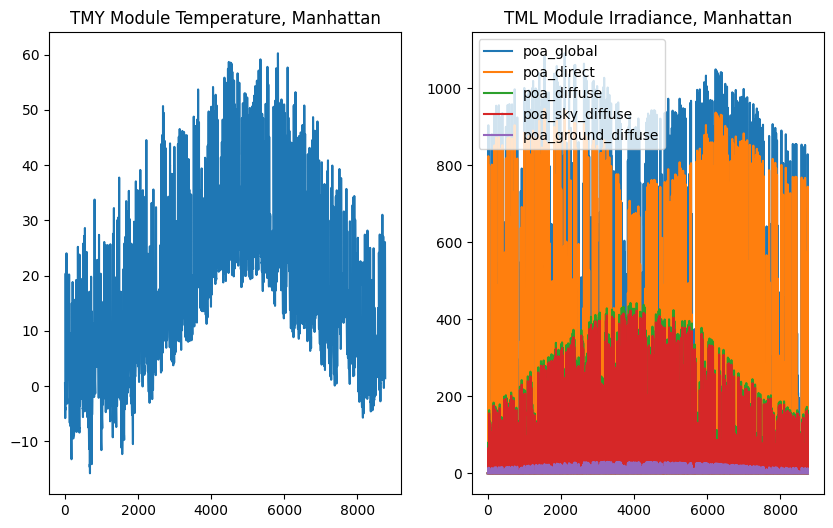

In [3]:
module_temps = pvdeg.temperature.module(
    weather_df=weather_df, meta=meta_dict, conf="open_rack_glass_glass"
)

poa_irradiance = pvdeg.spectral.poa_irradiance(weather_df=weather_df, meta=meta_dict)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(
    module_temps.values
)  # plotting the values in order because we are using tmy data so the years are not consistent within our data
plt.title("TMY Module Temperature, Manhattan")
plt.subplot(1, 2, 2)
plt.plot(poa_irradiance.values)
plt.legend(poa_irradiance.columns)
plt.title("TML Module Irradiance, Manhattan")
plt.show()

### Define Custom Expressions from Latex or 

We will use an altered arrhenius equation with an irrandiance relation (ignore the fact that this exists in pvdeg already).

$R_{D} = R_{0}I^{X}  e^{\frac{-{Ea}}{kT}}$ *ea is one variable so this may present some issues*  
the raw latex looks like this `R_{0}I^{X}  e^{\frac{-{Ea}}{kT}}`

In [4]:
lnR_0, I, X, Ea, k, T = sp.symbols("lnR_0 I X Ea k T")

ln_R_D_expr = (
    lnR_0 * I**X * sp.exp((-Ea) / (k * T))
)  # python exponentiation is ** rather than ^

# viewing output
ln_R_D_expr

I**X*lnR_0*exp(-Ea/(T*k))

### Calculating Degradation Expression

Generally more processing will have to happen outside of these functions than built in pvdeg functions. 
Here we are defining our arguments and correcting units. When trying to calculate using timeseries we will pass `pandas.Series` objects to the arguments.

Results should be strictly scrutinized to make sure the calculation is iterating over your series correctly. It will generally be easier to write python code
for more complex functions. This is about as complex as we will be able to get using arbitrary symbolic expressions if looping over timeseries data is required.

In [5]:
module_temps_k = module_temps + 273.15  # convert C -> K

poa_global = poa_irradiance[
    "poa_global"
]  # take only the global irradiance series from the total irradiance dataframe
poa_global_kw = poa_global / 1000  # [W/m^2] -> [kW/m^2]

### This is quite slow

In [6]:
values_kwarg = {
    "Ea": 62.08,  # activation energy, [kJ/mol]
    "k": 8.31446e-3,  # boltzmans constant, [kJ/(mol * K)]
    "T": module_temps_k,  # module temperature, [K]
    "I": poa_global_kw,  # module plane of array irradiance, [W/m2]
    "X": 0.0341,  # irradiance relation, [unitless]
    "lnR_0": 13.72,  # prefactor degradation [ln(%/h)]
}

res = pvdeg.symbolic.calc_kwarg_timeseries(expr=ln_R_D_expr, kwarg=values_kwarg)

### Total degradation

To calculate accumulated degradation, we can sum each of the substep values and convert to log scale (need to do this because prefactor was in log scale).

In [7]:
np.log10(res.sum())

np.float64(-5.890094732542499)

## Example with Single Values

leakage current
$I_{leak} = \frac{V_{bias}}{R_{enc}}$

$I_{leak}$, leakage current  
${V_{bias}}$, potential difference between cells and frame  
${R_{enc}}$, resistance of the encapsulant  

electric field
$E = \frac{V_{bias}}{d}$  

$E$, electric field  
$d$, thickness of encapsulant  

degradation rage
$D = k_{D} * E * I{leak}$  

$D$, degradation rate  
$k_D$, degradation constant  

In [8]:
k_d, E, Vbias, Rencap, d = sp.symbols("k_d E Vbias Rencap d")

pid = k_d * (Vbias / d) * (Vbias / Rencap)

In [9]:
import pvdeg

pid_kwarg = {
    "Vbias": 1000,
    "Rencap": 1e9,
    "d": 0.0005,
    "k_d": 1e-9,
}

res = pvdeg.symbolic.calc_kwarg_floats(expr=pid, kwarg=pid_kwarg)

res

2.00000000000000e-9

### Calculate Values in a Dataframe using a symbolic expression

After creating the symbolic expression in using latex with `pvdeg.symbolic.symbolic_from_latex`, feed it to the function to calculate the leakage current at each row in the dataframe.
This expression calculation only accesses one dataframe row at a time so we cannot do any summations or windowed timeseries averiging within the call. At this point, write your own python function. If you create functions that would be useful, please email us your source code or create an issue and copy and paste your code there. If it is relevant it may be added to the package (credit will be given).

In [10]:
# I_leak_expr = pid_kwarg["Vbias"] / pid_kwarg["Rencap"]
# pvdeg.symbolic.calc_df_symbolic(expr=I_leak_expr, df=values_df)